In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
sql = """
    SELECT
    *
    FROM personal_finance.transactions
"""

df = pd.read_gbq(sql, dialect='standard', project_id='rasmus-prod', progress_bar_type='tqdm')
df.to_csv('bq_data.csv', index=False)

/Users/rasmus/opt/miniconda3/envs/my_finance/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2155: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [2]:
df =pd.read_csv('bq_data.csv')
display(df)
print(df.info())

,date,commit_date,receiver,amount,category,commit_file_id
0,2023-04-26,2023-05-03,NaN,-2.00,UNCATEGORIZED,POP
1,2023-04-20,2023-05-03,H M,-39.99,HOUSEHOLD-ITEMS,POP
2,2023-04-24,2023-05-03,STADIUM,-66.48,HOBBIES,POP
3,2023-04-16,2023-05-03,KLARNA AB,-43.94,HOUSEHOLD-ITEMS,POP
4,2023-04-12,2023-05-03,KLARNA AB,-221.30,UNCATEGORIZED,POP
...,...,...,...,...,...,...
1188,2023-03-06,2023-04-04,SEPPÄLÄ SEIJA TUULIKKI,25.00,OTHER-INCOME,POP
1189,2023-03-21,2023-04-04,IKEA VANTAA IF CUSTOMER R,-9.68,FOOD,POP
1190,2023-03-20,2023-04-04,K-CITYMARKET ESPOO LEPPAV,-75.68,FOOD,POP
1191,2023-03-10,2023-04-04,MOBILEPAY KATARIINA SEPPÄLÄ,100.00,OTHER-INCOME,POP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1193 non-null   object 
 1   commit_date     1193 non-null   object 
 2   receiver        1141 non-null   object 
 3   amount          1193 non-null   float64
 4   category        1181 non-null   object 
 5   commit_file_id  1193 non-null   object 
dtypes: float64(1), object(5)
memory usage: 56.0+ KB
None


# Priors

,category,count,prior
0,CLOTHING,28,0.023470
1,COMMUTING,103,0.086337
2,ENTERTAINMENT,91,0.076278
3,FOOD,442,0.370495
4,HEALTH,37,0.031014
5,HOBBIES,59,0.049455
6,HOUSEHOLD-ITEMS,67,0.056161
7,INVESTING,21,0.017603
8,LIVING,54,0.045264
9,OTHER-INCOME,103,0.086337


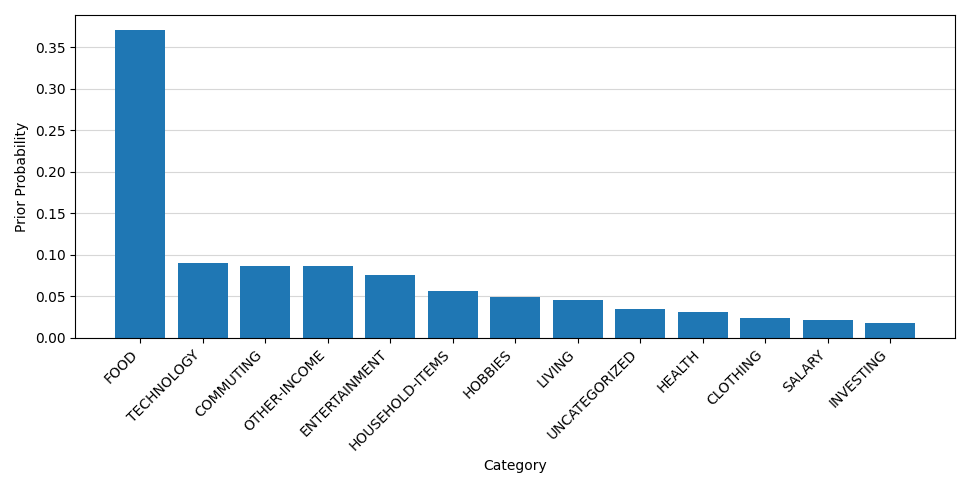

In [12]:
df_prior = df.copy()
rows = df_prior.shape[0]
df_prior = df_prior.groupby(['category']).agg(count=('category', 'count')).reset_index()
df_prior['prior'] = df_prior['count'] / rows
display(df_prior)
df_prior.sort_values(by='count', inplace=True, ascending=False)

plt.figure(1)
plt.clf()
plt.bar(df_prior['category'], df_prior['prior'])

plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Prior Probability')
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()

# Word propabilies P(Word|Category)

In [20]:
receiver = df['receiver'].str.split(' ')
receiver = receiver.drop_duplicates()
[print(row) for row in receiver.values];

nan
['H', 'M']
['STADIUM']
['KLARNA', 'AB']
['CHF*PNTpay']
['HSL', 'Mobiili']
['VEIKKAUS', 'OY']
['DNA', 'Welho', 'Oy']
['VR-YHTYMÄ', 'OY']
['Vattenfall', 'Oy']
['APPLE.COM/BILL']
['TOPI', 'FEELGOOD', 'K']
['VALKOINEN', 'PUU', 'C']
['VFI*VEIKKAUS', 'OY']
['VERKKOKAUPPA.COM']
['RASMUS', 'HAAPANIEMI']
['STOCKMANN', 'TAPIOLA']
['SUOMEN', 'OSUUSPANKKI']
['CHF*Krkkinen', 'Web', 'Oy']
['K-Supermarket', 'Derby']
['KLARNA', 'BANK', 'AB', 'PUBL']
['VERIFONE', 'FINLAND', 'OY']
['A', 'MEDIUM', 'CORPORATION']
['ADOBE', 'PHOTOGPHY', 'PLAN']
['ALEPA', 'KIVISTON', 'ASEMA']
['CENTAURUS', 'FINLAND', 'KY']
['KATJAN', 'VOHVELIKAHVILA']
['Tekniikan', 'akateemiset']
['K-citymarket', 'Kauhajoki']
['Kauhajoen', 'Ege', 'Kebab', 'Pi']
['R_VANTAA_Safiirikuja', '7']
['SEPPÄLÄ', 'ANTTI', 'SAMULI']
['R_SEINAeJOKI_Valtionkatu']
['SEPPÄLÄ', 'SEIJA', 'TUULIKKI']
['Bestseller', 'AS', 'JJ_FI_3071_']
['Espoon', 'I', 'Tapiolan', 'apteekk']
['R_HELSINKI_Tripla_Asema_L']
['MOBILEPAY', 'KATARIINA', 'SEPPÄLÄ']
['MOBILEPAY', 

In [34]:
receiver = df.loc[df['category'] == 'FOOD', 'receiver']
receiver = receiver.drop_duplicates().reset_index(drop=True)
receiver = receiver.to_list()
[print(row) for row in receiver];
print(len(receiver))

VALKOINEN PUU C
VFI*VEIKKAUS OY
K-Supermarket Derby
ALEPA KIVISTON ASEMA
KATJAN VOHVELIKAHVILA
K-citymarket Kauhajoki
Kauhajoen Ege Kebab Pi
R_VANTAA_Safiirikuja 7
R_SEINAeJOKI_Valtionkatu
R_HELSINKI_Tripla_Asema_L
nan
PRISMA SELLO
VFI*BURGERI 66
K-Market Perkkaa
Subway 65975 REDI
K-market Woikantori
Arlanda Walk Through
MOBILEPAY
MOB.PAY*RESQ
PAYTRAIL OYJ
SUBWAY AINOA
S-MARKET GRANI
AALTO TIETOTEKN
Foodora Finland
LIDL HKI KAMPPI
PRISMA ISO OMENA
STARSHIP ESTONIA
K-market Iso Omena
RAVINTOLA KUNINGAS
Teknologforeningen
ALEPA OTANIEMI UUSI
ESPRESSO HOUSE 1226
Fazer Ravintolat Oy
LIDL ESPOO ISO OMENA
K-supermarket Tapiola
LIDL ESPOO-LAAJALAHTI
R AALTOYO METROKESKUS
Aalto Kvarkki FI139965
Teboil Kaivoksela 7038
VFI*Teknologforeningen
MOB.PAY*BENJAMIN KYNGAS
Compass Group Finland Oy
MOB.PAY*ELIAS YL$-JARKKO
Avecra Oy Stop at station
K-CITYMARKET ESPOO ISO OM
K-CITYMARKET HELSINKI RUO
K-citymarket Espoo Leppav
MOB.PAY*KAISA MAARET KUKK
R HKI LAIVALAHDENPORTTI 3
ABC KELJONKANGAS
K-market Ma

In [45]:
[re.split(';|,|-|_|\*|\s', str(row).lower()) for row in receiver]

[['valkoinen', 'puu', 'c'],
 ['vfi', 'veikkaus', 'oy'],
 ['k', 'supermarket', 'derby'],
 ['alepa', 'kiviston', 'asema'],
 ['katjan', 'vohvelikahvila'],
 ['k', 'citymarket', 'kauhajoki'],
 ['kauhajoen', 'ege', 'kebab', 'pi'],
 ['r', 'vantaa', 'safiirikuja', '7'],
 ['r', 'seinaejoki', 'valtionkatu'],
 ['r', 'helsinki', 'tripla', 'asema', 'l'],
 ['nan'],
 ['prisma', 'sello'],
 ['vfi', 'burgeri', '66'],
 ['k', 'market', 'perkkaa'],
 ['subway', '65975', 'redi'],
 ['k', 'market', 'woikantori'],
 ['arlanda', 'walk', 'through'],
 ['mobilepay'],
 ['mob.pay', 'resq'],
 ['paytrail', 'oyj'],
 ['subway', 'ainoa'],
 ['s', 'market', 'grani'],
 ['aalto', 'tietotekn'],
 ['foodora', 'finland'],
 ['lidl', 'hki', 'kamppi'],
 ['prisma', 'iso', 'omena'],
 ['starship', 'estonia'],
 ['k', 'market', 'iso', 'omena'],
 ['ravintola', 'kuningas'],
 ['teknologforeningen'],
 ['alepa', 'otaniemi', 'uusi'],
 ['espresso', 'house', '1226'],
 ['fazer', 'ravintolat', 'oy'],
 ['lidl', 'espoo', 'iso', 'omena'],
 ['k', 'supe

# Gaussian Amount distribution

,category,count,mean,std
0,CLOTHING,25,-110.441200,204.865770
1,COMMUTING,100,-17.630600,22.229108
2,ENTERTAINMENT,87,-14.456552,18.644449
3,FOOD,435,-15.160851,17.860864
4,HEALTH,34,-50.389706,90.421548
5,HOBBIES,56,-74.509107,163.035254
6,HOUSEHOLD-ITEMS,64,-120.490469,271.793276
7,INVESTING,18,-677.777778,606.392957
8,LIVING,51,-357.997059,392.121206
9,OTHER-INCOME,98,154.524286,356.266622


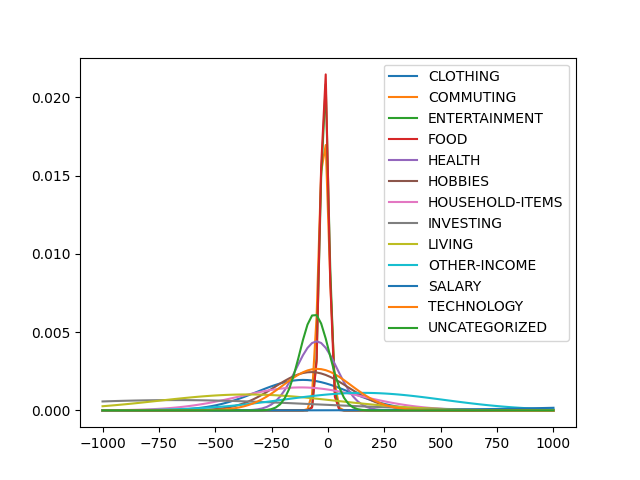

In [12]:
df_gaussian = df.loc[df['receiver'].notnull()].copy()
df_gaussian = df_gaussian.groupby(['category']).agg(count=('category', 'count'),
                                      mean=('amount', 'mean'),
                                      std=('amount', 'std')).reset_index()

display(df_gaussian)

plt.figure()
plt.clf()
x = np.linspace(-1000, 1000, 100)
[plt.plot(x, stats.norm.pdf(x, df_gaussian['mean'][i], df_gaussian['std'][i]), label=f"{df_gaussian['category'][i]}") for i in df_gaussian.index];
plt.legend()
plt.show()